### Importing the Libraries

In [12]:
# Needed to import data
import sys
import pandas as pd
import re
import dill
import os 

# Time 
import time

# bases
import numpy as np
import scipy

#pre-processing 
from sklearn.preprocessing import StandardScaler

#k-Fold cross 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#Ridge 
from sklearn.linear_model import Ridge

#plotting 
import matplotlib.pyplot as plt

#reproducability 
import random
random.seed(42)
np.random.seed(42)

### Setting up paths

In [3]:
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP')
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Vector Regression Baseline/Experimental Results/Vector_Base_Line/with k-fold cv kernel mapping before centering')

### Importing Data 

#### 1. Data Loading

In [4]:
#Load fMRI Resting State Data
with open("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Loading Structural FMRI data 
fMRI_language  = (scipy.io.loadmat("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/features_lang.mat")['features_lang'])

#Take the Transpose so that each Sample is a Row
fmri_rs = fmri_rs.T
fMRI_language = fMRI_language.T

#Get Split to divide into train + test(loaded data is in the form of features * sampels so need to transpose)
mat_file = scipy.io.loadmat("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

#Create Train and Test Arrays corresponding to Training and Test Subjects
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape Labels into Column Vectors

# Assuming fmri_rs and dMRI_streamlog are numpy arrays or can be converted to numpy arrays
X_train_fmri = fmri_rs[train_subjects]
Y_train_fmri = df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test_fmri = fmri_rs[test_subjects]
Y_test_fmri = df_test["varimax_cog"].to_numpy().reshape((-1, 1))

X_train_fmri_language  = fMRI_language[train_subjects]
X_test_fmri_language   = fMRI_language[test_subjects]





#### 3. Concatanating the vectors

In [5]:
# Check if number of samples match
assert X_train_fmri.shape[0] == X_train_fmri_language.shape[0], "Number of training samples do not match"
assert X_test_fmri.shape[0] == X_test_fmri_language.shape[0], "Number of testing samples do not match"

# Concatenate along the features axis (axis=1)
X_train_combined = np.concatenate((X_train_fmri, X_train_fmri_language), axis=1)
X_test_combined = np.concatenate((X_test_fmri, X_test_fmri_language), axis=1)

# The target variables remain the same
Y_train_combined = Y_train_fmri
Y_test_combined = Y_test_fmri

# Verify the shapes
print("X_train_combined shape:", X_train_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)
print("Y_train_combined shape:", Y_train_combined.shape)
print("Y_test_combined shape:", Y_test_combined.shape)

X_train = X_train_combined
X_test = X_test_combined
Y_train = Y_train_combined
Y_test = Y_test_combined

X_train_combined shape: (677, 159600)
X_test_combined shape: (76, 159600)
Y_train_combined shape: (677, 1)
Y_test_combined shape: (76, 1)


### Preprocessing

1. Transforming to kernel hiblert space.

In [6]:
#Row Wise Normalization of Samples
def normalize_rows(matrix: np.ndarray):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    return normalized_matrix

#Preprocess Data
X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)

2. Removing the intercept from the data

In [19]:

def LRR(X_train,Y_train,X_validatioon,Y_validation,alpha,Y_train_mean = None):

    #model 
    ridge_regression = Ridge(alpha=alpha,fit_intercept=False)
    #fitting model
    ridge_regression.fit(X_train,Y_train)
    #testing 

    if Y_train_mean is not None:
        Y_predicted = ridge_regression.predict(X_validatioon).flatten().reshape(-1,1) + Y_train_mean
    else:
        Y_predicted = ridge_regression.predict(X_validatioon).flatten().reshape(-1,1) 

    #error matrices 

    #nmse
    nmse    = (np.linalg.norm(Y_validation - Y_predicted)**2/(np.linalg.norm(Y_validation)**2))
    #r2
    numerator = np.sum((Y_validation - Y_predicted)**2)
    denominator = np.sum((Y_validation - np.mean(Y_validation))**2)
    r2 = 1 - (numerator / denominator)
    #correlation
    corr    = np.corrcoef(Y_validation.flatten(), Y_predicted.flatten())[0,1]
    
    return nmse,r2,corr

In [8]:
#number of samples in train and test
n_train = X_train.shape[0]
n_test = X_test.shape[0]



# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test)


#average response value
Y_train_mean = np.mean(Y_train)

# Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean

#printing the outcomes
print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)

Sample mean for each feature (across samples): [0.00539955 0.00586687 0.00328127 ... 0.00187997 0.00089592 0.00327504]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391


### K-Fold Cross Validation

In [11]:

# Number of folds we are using 
n_splits = 10
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#the regularization coefficients to search over
alphas = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]
#[0, 0.00001, 0.0001, 0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.4, 0.7, 1, 1.5, 2, 2.5, 3,3.5, 4, 5, 10, 15, 20]
#[0.07,0.08,0.09,0.1,0.12,0.14,0.16,0.18,2.0,2.5,3.0,3.5,4.0]

k_fold_results = np.zeros(shape=[n_splits,len(alphas),3])

#iterating over the folds
for fold,(train_ids,validation_ids) in enumerate(kfold.split(X_train)):

    #the training and validatiion data 
    X_train_fold,Y_train_fold = X_train[train_ids],Y_train[train_ids]
    X_validation_fold,Y_validation_fold = X_train[validation_ids],Y_train[validation_ids]
    
    #iterating over the alpha values 
    for alpha_idx,alpha in enumerate(alphas):
        nmse,r2,corr = LRR(X_train_fold,Y_train_fold,X_validation_fold,Y_validation_fold,alpha)
        k_fold_results[fold,alpha_idx,0] = nmse
        k_fold_results[fold,alpha_idx,1] = r2
        k_fold_results[fold,alpha_idx,2] = corr

        print(f"fold = {fold},alpha = {alpha},nmse = {nmse},r2 = {r2}, corr = {corr}")

#Choosing the best lambda

#array to hold all the sums
nmse_sum = np.zeros(len(alphas))

# Iterate over the folds and alpha values to accumulate nmse values
for alpha_idx in range(len(alphas)):
    for fold in range(n_splits):
        nmse_sum[alpha_idx] += k_fold_results[fold, alpha_idx, 0]

#best lambda 

best_alpha_idx = np.argmin(nmse_sum)
best_alpha = alphas[best_alpha_idx]        
print(f"The best alpha value is {best_alpha}")
        



fold = 0,alpha = 0.01,nmse = 0.52022067377924,r2 = 0.47442880363560047, corr = 0.6966921418655032
fold = 0,alpha = 0.02,nmse = 0.5194100205871295,r2 = 0.47524779447831134, corr = 0.6970718452806384
fold = 0,alpha = 0.03,nmse = 0.5189799021919893,r2 = 0.47568233668492876, corr = 0.6972312061661035
fold = 0,alpha = 0.04,nmse = 0.5188535481442792,r2 = 0.47580999029688176, corr = 0.6972116581769736
fold = 0,alpha = 0.05,nmse = 0.5189712215521433,r2 = 0.4756911066060395, corr = 0.6970461029932571
fold = 0,alpha = 0.06,nmse = 0.5192859211285419,r2 = 0.47537317031246296, corr = 0.6967609150988989
fold = 0,alpha = 0.07,nmse = 0.5197603049416123,r2 = 0.47489390741358584, corr = 0.6963774138801669
fold = 0,alpha = 0.08,nmse = 0.520364450363206,r2 = 0.47428354829483255, corr = 0.6959129607319207
fold = 1,alpha = 0.01,nmse = 0.7258799850922157,r2 = 0.2739779921071144, corr = 0.5322740700272534
fold = 1,alpha = 0.02,nmse = 0.7251152086109337,r2 = 0.2747429182215314, corr = 0.5331480576708997
fold =

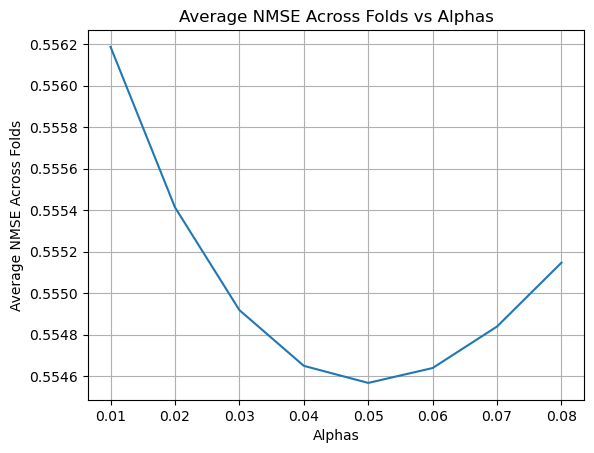

average performance metrics: [0.55456699 0.43438286 0.67415781]


In [16]:
average_nmse_accross_folds = nmse_sum/n_splits

plt.figure()
plt.plot(alphas, average_nmse_accross_folds)
plt.xlabel('Alphas')
plt.ylabel('Average NMSE Across Folds')
plt.title('Average NMSE Across Folds vs Alphas')
plt.grid(True)
plt.show()


average_results = np.mean(k_fold_results, axis=0)
print(f'average performance metrics: {average_results[best_alpha_idx]}')

### Training and Testing with best Lambda

In [20]:
import time
start_time = time.time()
nmse_best,r2_best,corr_best =  LRR(X_train,Y_train,X_test,Y_test,best_alpha,Y_train_mean=Y_train_mean)
end_time = time.time()
elapsed_time = end_time - start_time 
print(f'Time to run one experiment: {elapsed_time}')

Time to run one experiment: 28.95216989517212


### Reporting Errors

In [22]:
print(f"The best Lamda Values Selected After KFold CV: {best_alpha}")
print(f"Testing Normalized Mean Squred Error: {nmse_best}")
print(f"Testing R2: {r2_best}")
print(f"Testing Correlation: {corr_best}")

The best Lamda Values Selected After KFold CV: 0.05
Testing Normalized Mean Squred Error: 0.5966716685070238
Testing R2: 0.3603292221293981
Testing Correlation: 0.6232998930222745


### Saving Stuff

In [15]:

# Convert alphas list to a string for the file name
alphas_str = '_'.join(map(str, alphas))

# Define the content to write
results = (
    f"The best Lambda Values Selected After KFold CV: {best_alpha}\n"
    f"Testing Normalized Mean Squared Error: {nmse_best}\n"
    f"Testing R2: {r2_best}\n"
    f"Testing Correlation: {corr_best}\n"
)

# Define the file path
file_path = f'/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Vector Regression Baseline/Experimental Results/Vector_Base_Line/with concat k-fold cv kernel map centering fmri/with k-Fold cv std kernel map center/{alphas_str}results.txt'

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Write the results to a text file
with open(file_path, 'w') as file:
    file.write(results)

print(f"Results saved to {file_path}")


Results saved to /Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Vector Regression Baseline/Experimental Results/Vector_Base_Line/with concat k-fold cv kernel map centering fmri/with k-Fold cv std kernel map center/0.01_0.02_0.03_0.04_0.05_0.06_0.07_0.08results.txt
